In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


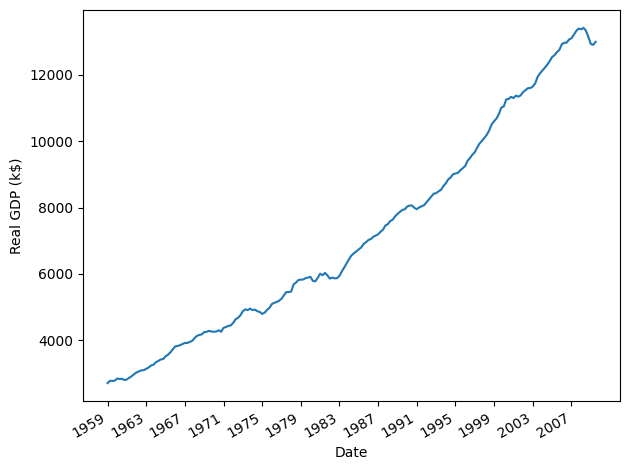

In [3]:
# Figure 9.1 in pg 181

fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH09_F01_peixeiro.png', dpi=300)

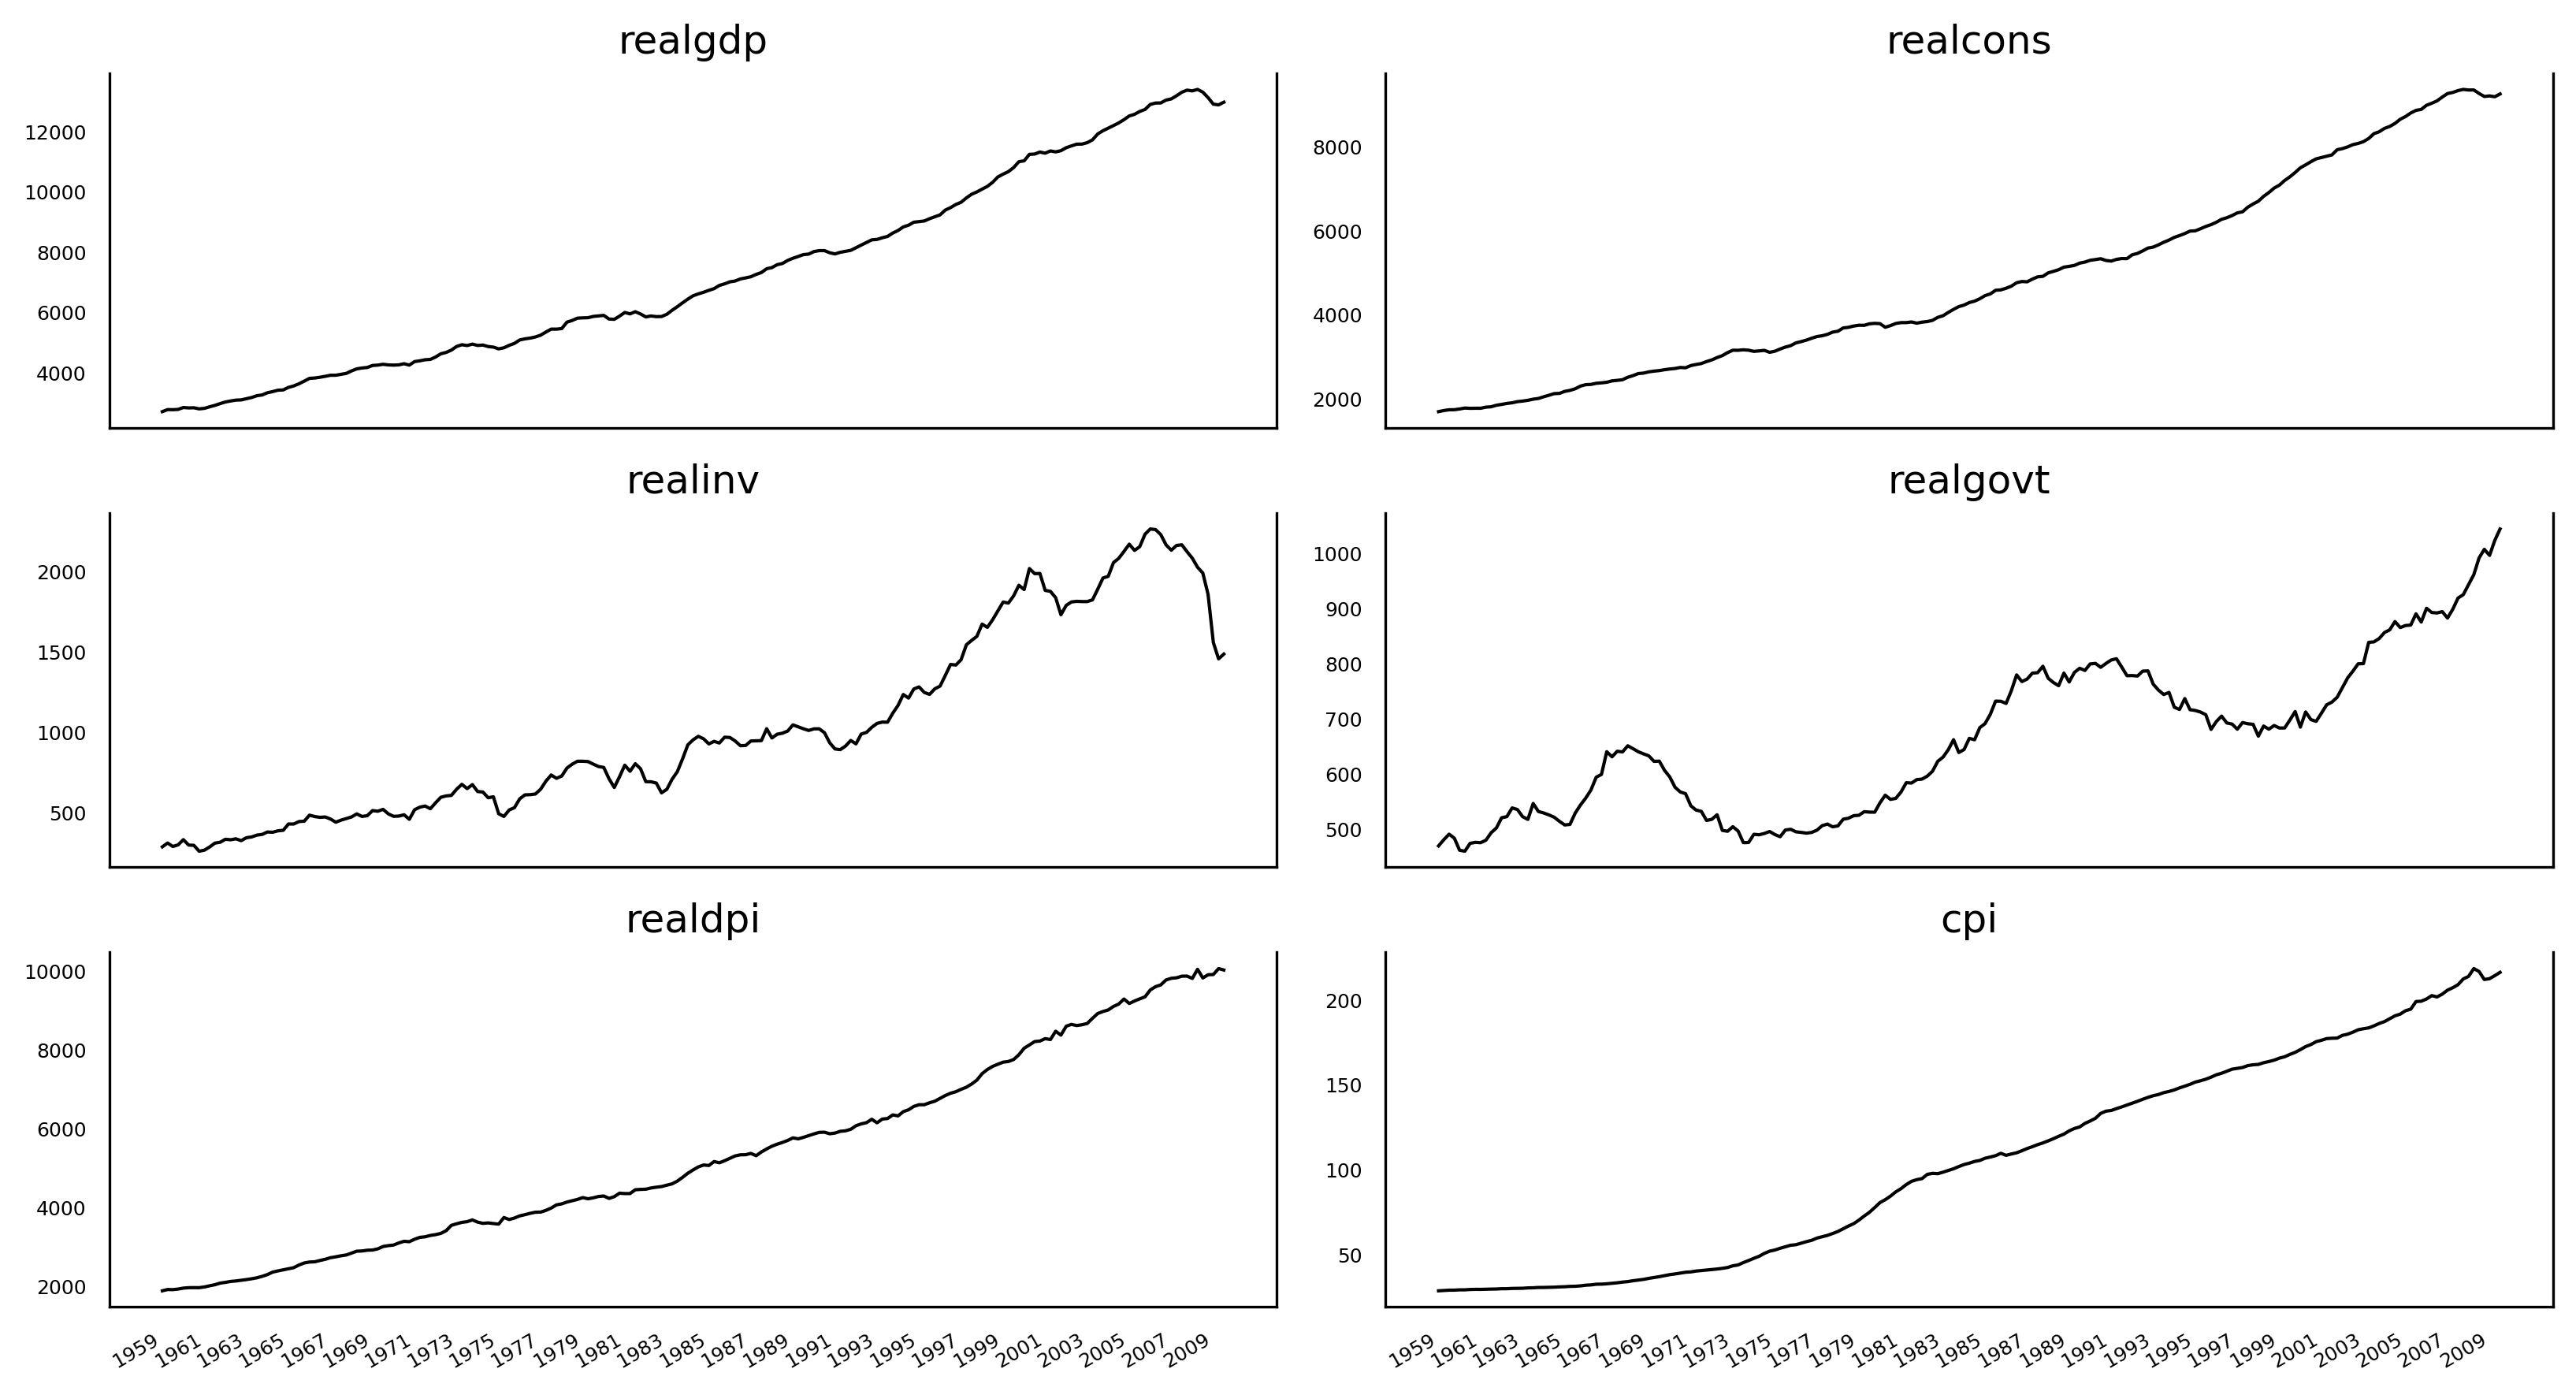

In [4]:
# Figure 9.2 in pg 185

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH09_F02_peixeiro.png', dpi=300)

In [5]:
# Pg 188
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

In [6]:
# Pg 188
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647095
p-value: 0.9982455372335032


In [7]:
# Pg 188
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])  # to do not include NaN

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [8]:
# Pg 188-189
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [9]:
# Pg 189
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [10]:
# Pg 189
target_train = target[:196]
exog_train = exog[:196]

# result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
# result_df

(p,q,P,Q)	AIC  
0	(2, 3, 0, 0)	1717.199708  
1	(3, 3, 0, 0)	1719.307540  
2	(2, 2, 1, 0)	1719.499686  
3	(3, 3, 0, 1)	1720.743937  
4	(3, 3, 1, 0)	1720.758715  

In [11]:
# Pg 190
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  196
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -842.750
Date:                            Wed, 11 Feb 2026   AIC                           1719.500
Time:                                    17:27:07   BIC                           1775.141
Sample:                                         0   HQIC                          1742.028
                                            - 196                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9958      0.055     18.108      0.000       0.888       1.104
realinv        1.0283      0.041   

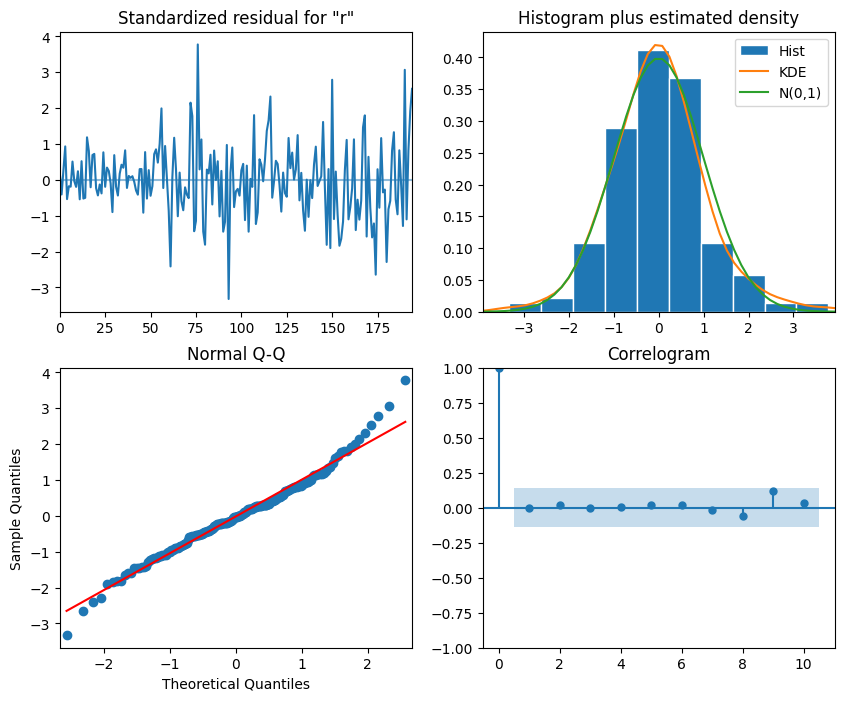

In [12]:
# Figure 9.6 in pg 192

best_model_fit.plot_diagnostics(figsize=(10,8))

plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

In [13]:
# Pg 191
residuals = best_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.006478,0.935852
2,0.028968,0.985620
3,0.040573,0.997853
4,0.137500,0.997742
5,0.168358,0.999417
6,0.172626,0.999900
7,0.173131,0.999985
8,0.246378,0.999991
9,0.279798,0.999998
10,0.288244,1.000000


In [14]:
# Pg 193 (error in book, wrong nameof function)
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(start=i, end=i+window-1, exog=exog[i:i+window])  # only out-of-sample prediction
            # some exog is necessary, by default exog=none, it gives error. 
            # IMPORTANT: We need exog[k] to forecast endog[k], only use:
            #       1. exog variable known in advance, or 
            #       2. exog that can forecast with high accuracy (or higher accuracy than the target and that is good enough for us) or 
            #       3. when we can obtain exog[k] faster than exog[k]
            #oos_pred = predictions.predicted_mean.iloc[i:i+window]   #[202,203] refers to index 202 taht exists, but uses the nomenclature of index 203 that does not exist: error
            oos_pred = predictions.predicted_mean.iloc[-window:]
            print(len(endog[:i]), len(exog[:i]), len(exog[i:i+window]), len(predictions.predicted_mean), predictions.predicted_mean.shape)
            print(endog[:i].index, exog[:i].index, exog[i:i+window].index, predictions.predicted_mean.index)
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [15]:
# Pg 193 
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

196 196 1 1 (1,)
RangeIndex(start=0, stop=196, step=1) RangeIndex(start=0, stop=196, step=1) RangeIndex(start=196, stop=197, step=1) RangeIndex(start=196, stop=197, step=1)
197 197 1 1 (1,)
RangeIndex(start=0, stop=197, step=1) RangeIndex(start=0, stop=197, step=1) RangeIndex(start=197, stop=198, step=1) RangeIndex(start=197, stop=198, step=1)
198 198 1 1 (1,)
RangeIndex(start=0, stop=198, step=1) RangeIndex(start=0, stop=198, step=1) RangeIndex(start=198, stop=199, step=1) RangeIndex(start=198, stop=199, step=1)
199 199 1 1 (1,)
RangeIndex(start=0, stop=199, step=1) RangeIndex(start=0, stop=199, step=1) RangeIndex(start=199, stop=200, step=1) RangeIndex(start=199, stop=200, step=1)
200 200 1 1 (1,)
RangeIndex(start=0, stop=200, step=1) RangeIndex(start=0, stop=200, step=1) RangeIndex(start=200, stop=201, step=1) RangeIndex(start=200, stop=201, step=1)
201 201 1 1 (1,)
RangeIndex(start=0, stop=201, step=1) RangeIndex(start=0, stop=201, step=1) RangeIndex(start=201, stop=202, step=1) Ra

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13376.291034
197,13415.266,13366.865,13344.827276
198,13324.600,13415.266,13334.737824
199,13141.920,13324.600,13132.852899
200,12925.410,13141.920,12859.858684
201,12901.504,12925.410,12861.234228
202,12990.341,12901.504,13044.704127


In [16]:
# Pg 194
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# Pg 194
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.2826330124773946


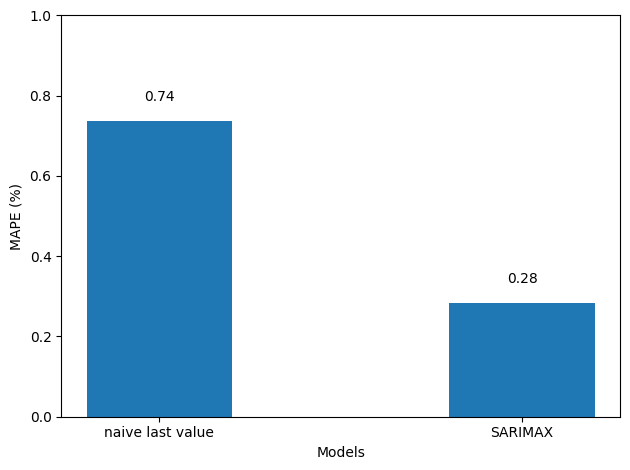

In [18]:
# Figure 9.7 in pg 194

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)

In [19]:
best_model_fit.aic

np.float64(1719.4996862667272)

In [20]:
best_model_fit.mse

np.float64(3083.65774800281)

In [21]:
best_model_fit.mae

np.float64(17.405268938831306)